In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from em import em_gaussian_mixture
from old_faithful import get_old_faithful_data

In [2]:
save_path = os.path.expanduser("~/vaes_ptorch/data")
er, waits = get_old_faithful_data(save=True, save_dir=save_path)

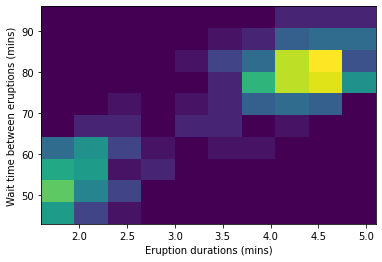

In [3]:
plt.hist2d(er, waits, alpha=1.0)
plt.xlabel("Eruption durations (mins)")
plt.ylabel("Wait time between eruptions (mins)");

In [4]:
data = np.concatenate([er.reshape(-1, 1), waits.reshape(-1, 1)], 1)
theta = em_gaussian_mixture(data, 2, 1000)
theta

Theta(mu=[array([ 2.03638845, 54.47851638]), array([ 4.28966197, 79.96811517])], sigma=[array([[ 0.06916767,  0.43516762],
       [ 0.43516762, 33.69728207]]), array([[ 0.16996844,  0.94060932],
       [ 0.94060932, 36.04621132]])], gamma=array([0.35587286, 0.64412714]))

In [5]:
import torch
import torch.nn as nn
import torch.utils.data as tdata
from vaes_ptorch import VAE, GaussianMLP, TrainArgs, train
from vaes_ptorch.args import KLAnnealing

In [6]:
def scale_data(data):  # of shape n, p
    mean_, std_ = data.mean(0), data.std(0)
    return (data - mean_) / std_, (mean_, std_)


def rescale_data(data, mean_std):
    mean_, std_ = mean_std
    return mean_ + std_ * data

In [7]:
scaled, mean_std = scale_data(data)
dataset = tdata.TensorDataset(torch.from_numpy(scaled).float())
dataloader = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

In [38]:
latent_dim = 2
data_dim = 2
h_size = 128
h_layers = 10
lr = 1e-3
num_epochs = 500
print_every = 100
reconstruction_only = 100
kl_warmup = 2000

In [39]:
encoder = GaussianMLP(
    in_dim=data_dim, h_dims=[h_size] * h_layers, out_dim=latent_dim
)
decoder = GaussianMLP(
    in_dim=latent_dim, h_dims=[h_size] * h_layers, out_dim=data_dim
)
vae = VAE(encoder=encoder, decoder=decoder)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)
train_args = TrainArgs(
    num_epochs=num_epochs,
    print_every=print_every,
    smoothing=0.9,
    kl_annealing=KLAnnealing(num_epochs, reconstruction_only, kl_warmup),
)

In [40]:
vae = train(data=dataloader, vae=vae, optimizer=optimizer, args=train_args)

Step: 100 | ELBO: 0.03120 | KL scale: 0.000
NLL: 0.02839 | KL: 28152.00391
Step: 200 | ELBO: 0.02628 | KL scale: 0.000
NLL: 0.02206 | KL: 25772.08203
Step: 300 | ELBO: 0.02671 | KL scale: 0.000
NLL: 0.03806 | KL: 2829.11523
Step: 400 | ELBO: 0.26158 | KL scale: 0.017
NLL: 0.07045 | KL: 5.92080
Step: 500 | ELBO: 0.18044 | KL scale: 0.034
NLL: 0.07621 | KL: 3.81139
Step: 600 | ELBO: 0.23894 | KL scale: 0.050
NLL: 0.06240 | KL: 2.65681
Step: 700 | ELBO: 0.31596 | KL scale: 0.067
NLL: 0.09518 | KL: 4.20499
Step: 800 | ELBO: 0.34403 | KL scale: 0.084
NLL: 0.10393 | KL: 3.50503
Step: 900 | ELBO: 0.38304 | KL scale: 0.100
NLL: 0.07279 | KL: 2.50947
Step: 1000 | ELBO: 0.46123 | KL scale: 0.117
NLL: 0.10891 | KL: 2.99879
Step: 1100 | ELBO: 0.49207 | KL scale: 0.134
NLL: 0.08829 | KL: 3.28119
Step: 1200 | ELBO: 0.54391 | KL scale: 0.150
NLL: 0.35807 | KL: 2.13162
Step: 1300 | ELBO: 0.58850 | KL scale: 0.167
NLL: 0.08513 | KL: 2.95850
Step: 1400 | ELBO: 0.62909 | KL scale: 0.183
NLL: 0.13940 | KL

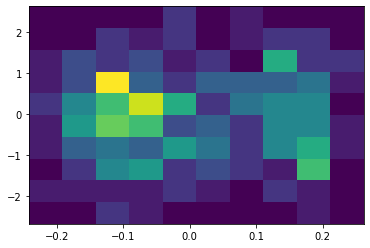

In [42]:
test = torch.from_numpy(scaled).float()

# TODO - better this
vae.eval()
with torch.no_grad():
    out = vae(test)
    z_samples = out.mu_z + torch.randn_like(out.mu_z) * torch.sqrt(out.sig_z)
    mu_x, sig_x = vae.decoder(z_samples)
    x_samples = mu_x + torch.randn_like(mu_x) * torch.sqrt(sig_x)
    z_2d = z_samples.detach().numpy()
    x_2d = rescale_data(x_samples.detach().numpy(), mean_std)
    plt.hist2d(z_2d[:, 0], z_2d[:, 1])
    plt.hist2d(x_2d[:, 0], x_2d[:, 1])

In [ ]:
# mu = torch.tensor([[1.0, -1.0,]])
# sig = torch.tensor([[2.0, 2.0]])
# t1 = np.linspace(0.1, 1.0)
# X, Y = np.meshgrid(t1, t1)
# Z = np.zeros_like(X)
# for i in range(t1.shape[0]):
#     for j in range(t1.shape[0]):
#         Z[i, j] += gaussian_kl(
#             left_mu=X[i, j] * mu,
#             left_sig=Y[i, j] * sig,
#             right_mu=torch.zeros_like(mu),
#             right_sig=torch.ones_like(sig),
#         )
#         Z[i, j] += nn.GaussianNLLLoss()(mu, X[i, j] * mu, Y[i, j] * sig)

# plt.contour(X, Y, Z, 20, cmap="RdGy")
# plt.colorbar()